# Whatsapp Chat Analysis


In [1]:
%config IPCompleter.greedy=True

In [2]:
pip install numpy pandas matplotlib seaborn wordcloud emoji jovian --upgrade  


In [3]:
import re
import jovian
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter


## Data Preprocessing


The split_format used can be referred from the regex cheatsheet- https://www.rexegg.com/regex-quickstart.html <br>
The date_time format can be referred from-http://strftime.org/ <br>
I have made use of a custom format as my Whatsapp chats were imported in another format.

In [4]:

def rawToDf(file, key):
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : '\[\d{2}/\d{2}/\d{4},\s\d{1,2}:\d{2}:\d{2}\s[AP][M]\]\s'
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': '[%d/%m/%Y, %I:%M:%S %p] '
    }
    
    with open(file, 'r', encoding = 'utf8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n'))  # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df
        

## Importing the data 

In [5]:
df = rawToDf('whatsapp-chat-data.txt', 'custom')

In [6]:
df.tail()

,date_time,user,msg
1025,2020-12-12 14:38:56,Ardra,But can’t
1026,2020-12-12 14:51:23,Sahil,Blue Label
1027,2020-12-12 15:45:45,Sonu,Cute
1028,2020-12-12 17:30:45,Anagha,YAAAAAAAAY ‎
1029,2020-12-12 19:15:04,Sahil,‎sticker omitted


In [7]:
df.shape


(1030, 3)

In [8]:
me = "Sahil"

In [9]:
df

,date_time,user,msg
0,2018-10-03 21:40:14,Alfie's bitches,‎Messages and calls are end-to-end encrypted. ...
1,2018-10-03 21:40:14,grp_notif,‎Sonu created this group
2,2018-10-03 21:40:14,grp_notif,‎You were added
3,2020-05-27 20:44:05,Sonu,How's the exam stress ma friends
4,2020-05-27 20:44:08,Sonu,Doing good?
...,...,...,...
1025,2020-12-12 14:38:56,Ardra,But can’t
1026,2020-12-12 14:51:23,Sahil,Blue Label
1027,2020-12-12 15:45:45,Sonu,Cute
1028,2020-12-12 17:30:45,Anagha,YAAAAAAAAY ‎


In [10]:
df['user'] #displaying the user column

0       Alfie's bitches
1             grp_notif
2             grp_notif
3                  Sonu
4                  Sonu
             ...       
1025              Ardra
1026              Sahil
1027               Sonu
1028             Anagha
1029              Sahil
Name: user, Length: 1030, dtype: object

In [11]:
df['msg'] #displaying the msg column

0       ‎Messages and calls are end-to-end encrypted. ...
1                               ‎Sonu created this group 
2                                        ‎You were added 
3                       How's the exam stress ma friends 
4                                            Doing good? 
                              ...                        
1025                                           But can’t 
1026                                          Blue Label 
1027                                                Cute 
1028                                         YAAAAAAAAY ‎
1029                                    ‎sticker omitted 
Name: msg, Length: 1030, dtype: object

In [12]:
df.dtypes

date_time    datetime64[ns]
user                 object
msg                  object
dtype: object

## Data Cleansing
We will now get rid of unwanted rows of data from our dataframe such as group notifications, omitted media, etc.


In [13]:
grp_notif = df[df['user'] == "grp_notif"]
grp_notif.shape

(4, 3)

In [14]:
grp_notif

,date_time,user,msg
1,2018-10-03 21:40:14,grp_notif,‎Sonu created this group
2,2018-10-03 21:40:14,grp_notif,‎You were added
66,2020-06-17 19:35:46,grp_notif,‎Anagha changed this group's icon ‎
638,2020-08-24 19:16:53,grp_notif,‎Ardra changed this group's icon


In [15]:
df['user'].unique()

array(["Alfie's bitches", 'grp_notif', 'Sonu', 'Ardra', 'Sahil', 'Anagha'],
      dtype=object)

In [16]:
df.iloc[3] #locating a particular row

date_time                  2020-05-27 20:44:05
user                                      Sonu
msg          How's the exam stress ma friends 
Name: 3, dtype: object

In [17]:
df.drop(grp_notif.index, inplace = True)

In [18]:
df.drop([0], axis = 0, inplace = True)
df.head(5)


,date_time,user,msg
3,2020-05-27 20:44:05,Sonu,How's the exam stress ma friends
4,2020-05-27 20:44:08,Sonu,Doing good?
5,2020-05-27 20:44:17,Sonu,Got saahu tomm ay?
6,2020-05-27 20:44:26,Ardra,Conflict for us
7,2020-05-27 20:44:29,Ardra,Sahu for anaga


In [19]:
df.shape

(1025, 3)

In [20]:
df.reset_index(inplace=True, drop=True)
df.shape

(1025, 3)

## Q1) Who is the most and least active member of the group?


In [21]:
df.groupby("user")["msg"].count().sort_values(ascending = False)

user
Ardra     349
Sonu      310
Sahil     195
Anagha    171
Name: msg, dtype: int64

From the above analysis, it is obvious that Ardra is the most active member and Anagha is the least active.

## Q2) Emojis used by Ardra

In [22]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == "Ardra":
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found] += 1

In [23]:
for item in emoji_ctr.most_common():
    print(item[0] + " - " + str(item[1]))

😂 - 67
🙂 - 6
🙃 - 6
♥ - 2


## Q3) Hourly Activity drawn based on group interaction

<AxesSubplot:xlabel='hour'>

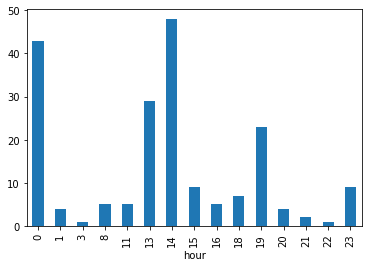

In [24]:
df['hour'] = df['date_time'].apply(lambda x: x.hour)
df[df['user']==me].groupby(['hour']).size().sort_index().plot(x="hour", kind='bar')

## Q4) Difference in Weekend vs Weekday pattern usage.

In [25]:
df['weekday'] = df['date_time'].apply(lambda x: x.day_name()) 

In [26]:
df['is_weekend'] = df['weekday'].isin(['Friday', 'Saturday'])

In [27]:
msgs_per_user  = df['user'].value_counts(sort=True)
msgs_per_user

Ardra     349
Sonu      310
Sahil     195
Anagha    171
Name: user, dtype: int64

In [28]:
df.head()

,date_time,user,msg,hour,weekday,is_weekend
0,2020-05-27 20:44:05,Sonu,How's the exam stress ma friends,20,Wednesday,False
1,2020-05-27 20:44:08,Sonu,Doing good?,20,Wednesday,False
2,2020-05-27 20:44:17,Sonu,Got saahu tomm ay?,20,Wednesday,False
3,2020-05-27 20:44:26,Ardra,Conflict for us,20,Wednesday,False
4,2020-05-27 20:44:29,Ardra,Sahu for anaga,20,Wednesday,False


<AxesSubplot:xlabel='user', ylabel='count'>

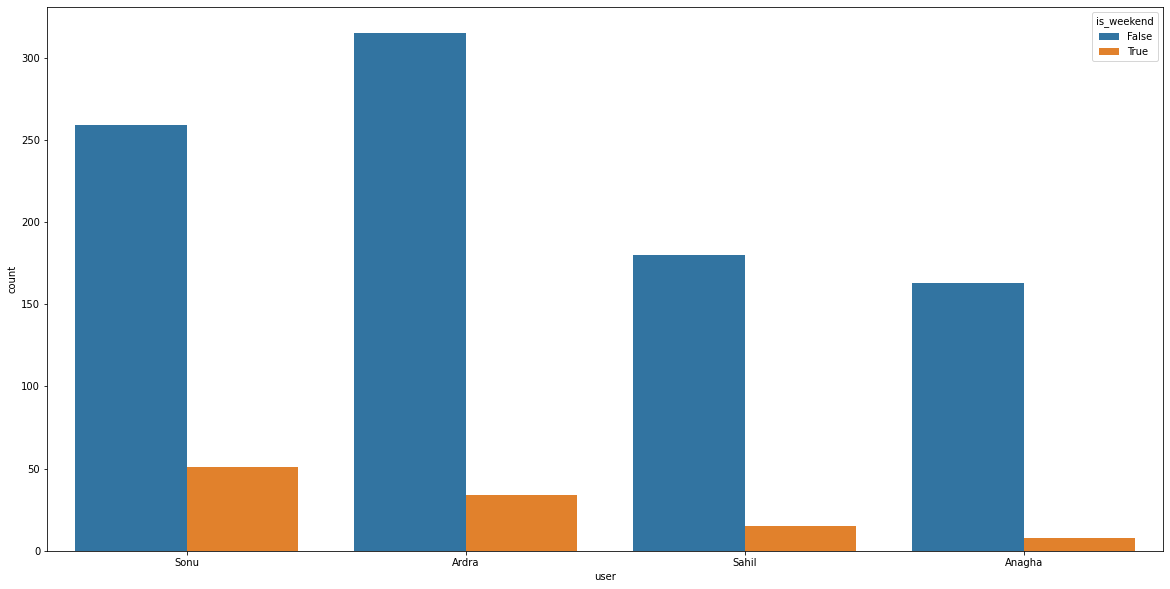

In [29]:
plt.figure(figsize=(20,10))
sns.countplot(x="user", hue="is_weekend", data=df)

Here, False represents weekday and True represents weekend.

## Q5) Day wise usage Analysis-  Graphical

<AxesSubplot:xlabel='user', ylabel='count'>

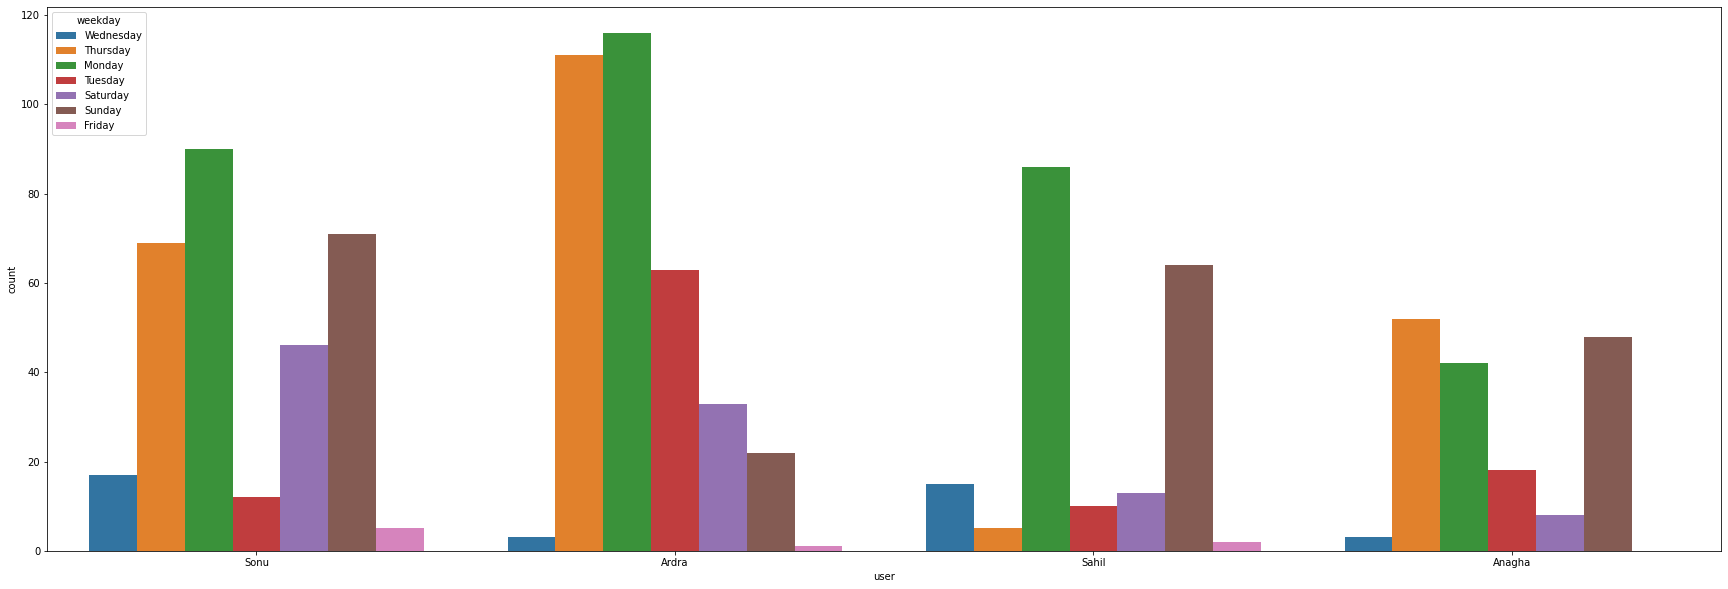

In [30]:
plt.figure(figsize=(30,10))
sns.countplot(x="user", hue="weekday", data=df)

## Day wise usage- Pivot Table

In [31]:
df.pivot_table(index='user',values = 'msg', columns = 'weekday', aggfunc= 'count').fillna(0)

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
user,,,,,,,
Anagha,0.0,42.0,8.0,48.0,52.0,18.0,3.0
Ardra,1.0,116.0,33.0,22.0,111.0,63.0,3.0
Sahil,2.0,86.0,13.0,64.0,5.0,10.0,15.0
Sonu,5.0,90.0,46.0,71.0,69.0,12.0,17.0


## Q6) Most usage- Time of day

In [32]:
x=df.groupby(['hour','weekday']).msg.size().reset_index()
x2=x.pivot(index='hour', columns='weekday', values='msg')
x2

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,1.0,NaN,6.0,145.0,157.0,NaN,NaN
1,NaN,NaN,2.0,4.0,NaN,NaN,NaN
2,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,1.0,NaN,NaN,NaN,NaN
8,NaN,1.0,NaN,1.0,5.0,NaN,2.0
9,NaN,1.0,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,12.0,NaN,NaN,6.0,12.0
13,NaN,83.0,47.0,21.0,NaN,18.0,NaN


<AxesSubplot:xlabel='weekday', ylabel='hour'>

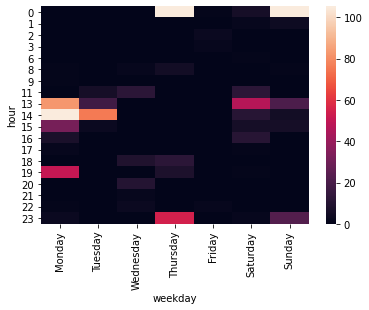

In [33]:
# we create a list of days to reorder the days from Start to end of the week and replace NaN values with 0
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] 
sns.heatmap(x2[days].fillna(0), robust=True)

## Q7) What are my most common words?

In [34]:
comment_words = ' '
stopwords = STOPWORDS.update(['okay', 'bye', 'is', 'and', 'on', 'at','omitted','sticker','image'])
  
for val in df.msg.values: 
    val = str(val) 
    tokens = val.split() 
        
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)

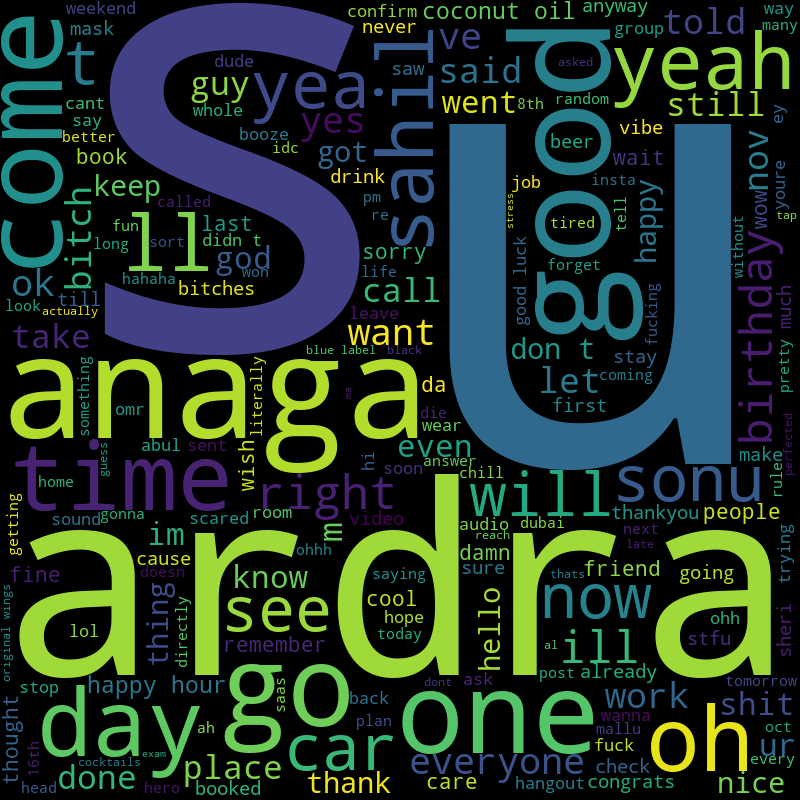

In [35]:
wordcloud.to_image()